In [48]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

In [49]:
df=pd.read_csv("sms_spam_ham_dataset.csv",encoding="latin-1")

In [50]:
df = df.dropna(how="any", axis=1)
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
#Finding length of each Message
df['text_len'] = df['Message'].apply(lambda x: len(x.split(' ')))
df.head()

,Label,Message,text_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [52]:
#Encoding Spam-1 and Ham-0
le = LabelEncoder()
le.fit(df['Label'])

df['Label_Encoded'] = le.transform(df['Label'])
df.head()

,Label,Message,text_len,Label_Encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,0
1,ham,Ok lar... Joking wif u oni...,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,1
3,ham,U dun say so early hor... U c already then say...,11,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,0


In [53]:
#Finding count of ham and spam messages
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

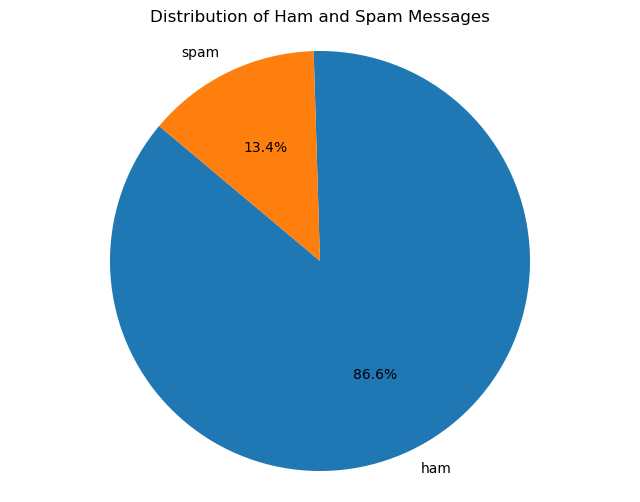

In [54]:
labels = df['Label'].value_counts().index
sizes = df['Label'].value_counts().values

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Ham and Spam Messages')
plt.show()

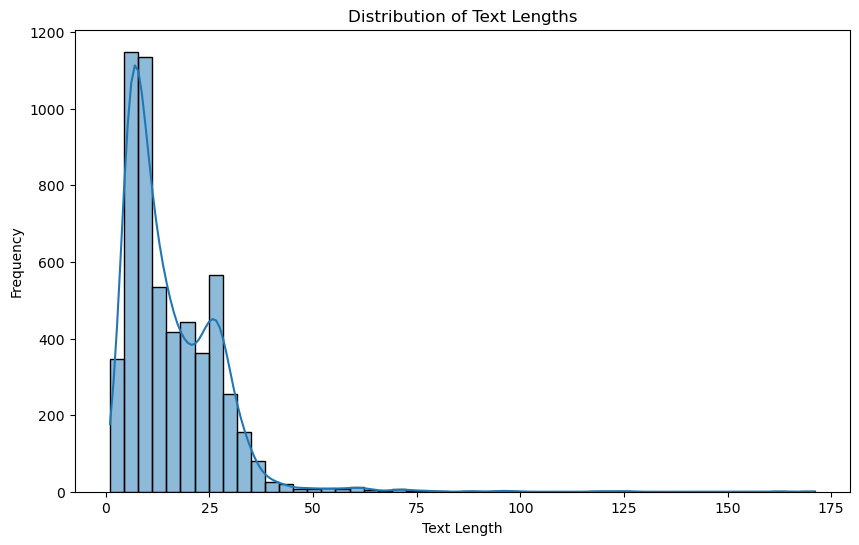

In [55]:
text_lengths=df['text_len']
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=50, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# Data PreProcessing

In [56]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [57]:
df['Message_Clean'] = df['Message'].apply(clean_text)
df.head()

,Label,Message,text_len,Label_Encoded,Message_Clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,0,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,1,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,0,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,0,nah i dont think he goes to usf he lives aroun...


In [58]:
#Removing Stop Words
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['Message_Clean'] = df['Message_Clean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Label,Message,text_len,Label_Encoded,Message_Clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,0,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,1,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,0,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,0,nah think goes usf lives around though


In [59]:
#Stemming
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
df['Message_Clean'] = df['Message_Clean'].apply(stemm_text)
df.head()

,Label,Message,text_len,Label_Encoded,Message_Clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,0,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,1,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,0,dun say earli hor c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,0,nah think goe usf live around though


In [60]:
x = df['Message_Clean']
y = df['Label_Encoded']

print(len(x), len(y))

5572 5572


# Modelling and Embedding

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [62]:


# Assuming x_train and x_test are lists of tokenized documents
# Preprocess and tokenize your text data here

# Train or load a pre-trained Word2Vec model
word2vec_model = Word2Vec(sentences=x_train, vector_size=100, window=5, min_count=1)

# Generate word embeddings for each document
def document_embedding(document, model):
    vectors = [model.wv[word] for word in document if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

x_train_w2v = np.array([document_embedding(doc, word2vec_model) for doc in x_train])
x_test_w2v = np.array([document_embedding(doc, word2vec_model) for doc in x_test])


In [63]:
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # True Skill Statistic (TSS)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    tss = sensitivity + specificity - 1

    # Heidke Skill Score (HSS)
    n = tp + tn + fp + fn
    hss = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
    hss=np.round(hss,2)
    tss=np.round(tss,2)
    accuracy=accuracy_score(y_true,y_pred).round(2)
    precision = precision_score(y_true,y_pred).round(2)
    recall = recall_score(y_true,y_pred).round(2)
    f1 = f1_score(y_true,y_pred).round(2)


    return {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn, 'TSS': tss, 'HSS': hss,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1-Score':f1}

# Random Forest Classifier

In [64]:
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
rfc.fit(x_train_w2v, y_train)

# Predict on test data
y_pred = rfc.predict(x_test_w2v)
accuracy_score(y_test,y_pred)

0.9504666188083274

In [65]:
y_train=y_train.to_numpy()

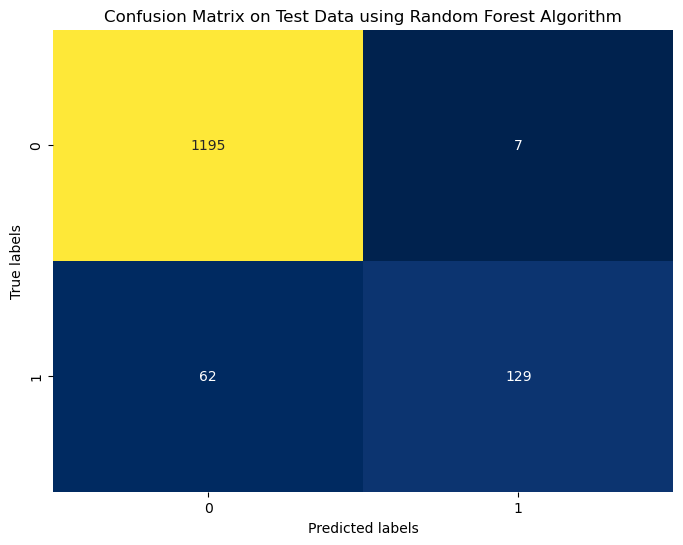

In [66]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Data using Random Forest Algorithm')
plt.show()

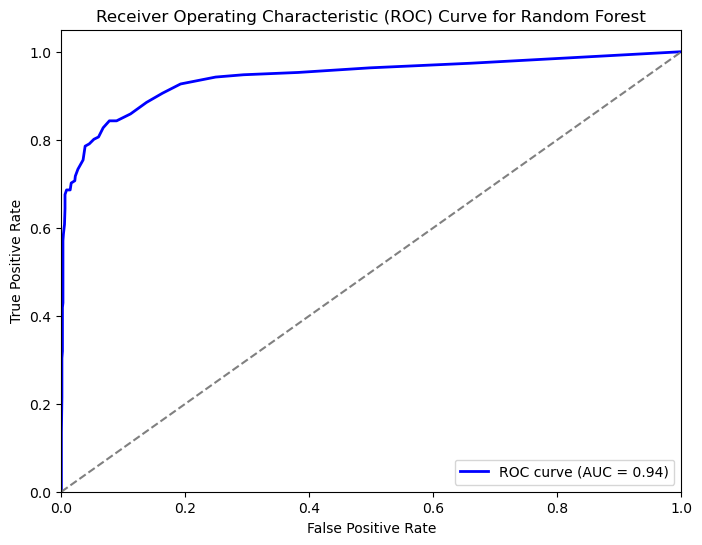

In [67]:
y_proba = rfc.predict_proba(x_test_w2v)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

In [68]:
# Define the number of folds
num_folds = 10

# Initialize KFold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# Lists to store evaluation metrics for each fold
fold_metrics = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(x_train_w2v), 1):
    X_train, X_test = x_train_w2v[train_index], x_train_w2v[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Initialize and train the RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=50, random_state=2)
    rfc.fit(X_train, y_train_fold)

    # Predict on the test set
    y_pred_fold = rfc.predict(X_test)
    metrics=calculate_metrics(y_test_fold, y_pred_fold)

    # Store metrics for this fold
    fold_metrics.append(metrics)
# Create DataFrame from fold_metrics list
df_results_Random_Forest = pd.DataFrame(fold_metrics)

# Display the results
df_results_Random_Forest

,TP,TN,FP,FN,TSS,HSS,Accuracy,Precision,Recall,F1-Score
0,26,367,4,21,0.54,0.64,0.94,0.87,0.55,0.68
1,37,357,7,17,0.67,0.72,0.94,0.84,0.69,0.76
2,37,359,6,16,0.68,0.74,0.95,0.86,0.70,0.77
3,40,356,2,20,0.66,0.76,0.95,0.95,0.67,0.78
4,45,349,4,20,0.68,0.76,0.94,0.92,0.69,0.79
5,37,359,3,19,0.65,0.74,0.95,0.92,0.66,0.77
6,42,356,3,17,0.70,0.78,0.95,0.93,0.71,0.81
7,46,360,3,9,0.83,0.87,0.97,0.94,0.84,0.88
8,44,355,7,12,0.77,0.80,0.95,0.86,0.79,0.82
9,28,361,5,23,0.54,0.63,0.93,0.85,0.55,0.67


In [69]:
# Average of 10 Folds execution
drf={}
for i in df_results_Random_Forest.columns:
  drf[i]=df_results_Random_Forest[i].mean().round(2)
print("Average of 10 Folds")
print(drf)

Average of 10 Folds
{'TP': 38.2, 'TN': 357.9, 'FP': 4.4, 'FN': 17.4, 'TSS': 0.67, 'HSS': 0.74, 'Accuracy': 0.95, 'Precision': 0.89, 'Recall': 0.68, 'F1-Score': 0.77}


In [70]:
df_results_Random_Forest.to_csv("df_results_Random_Forest.csv")

# Naive Bayes

In [71]:
nb = GaussianNB()
nb.fit(x_train_w2v, y_train)
y_pred = nb.predict(x_test_w2v)
accuracy_score(y_test,y_pred)

0.8571428571428571

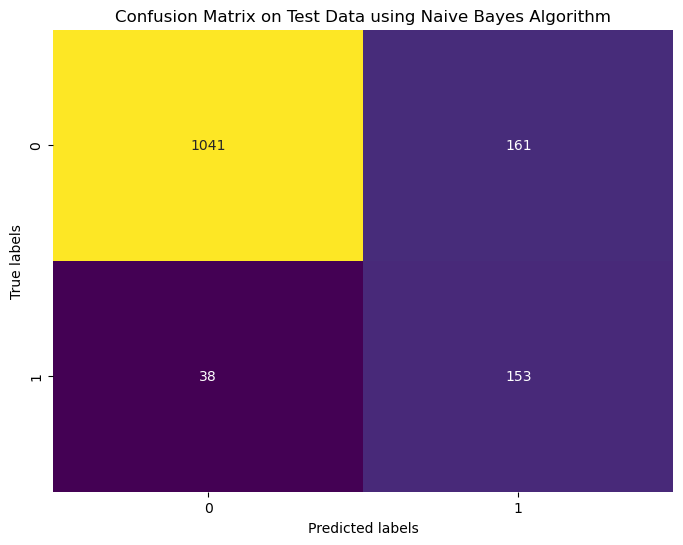

In [72]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Data using Naive Bayes Algorithm')
plt.show()

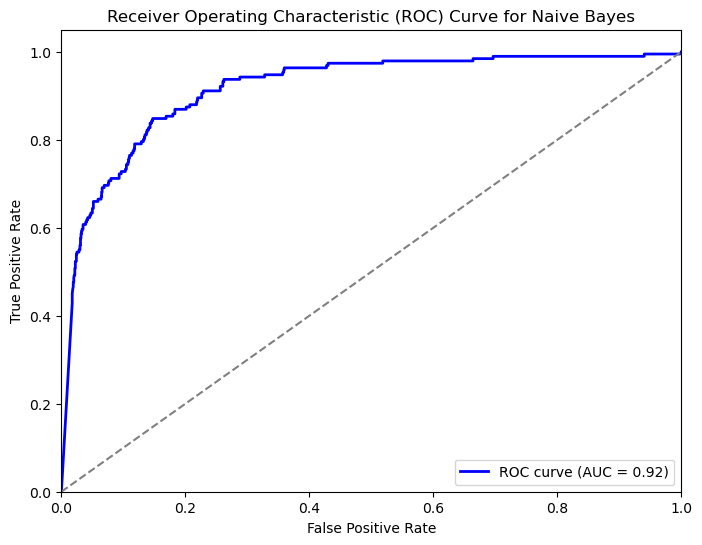

In [73]:
y_proba = nb.predict_proba(x_test_w2v)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()

In [74]:
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_metrics = []
for fold, (train_index, test_index) in enumerate(kf.split(x_train_w2v), 1):
    X_train, X_test = x_train_w2v[train_index], x_train_w2v[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    nb = GaussianNB()
    nb.fit(X_train, y_train_fold)
    y_pred_fold = nb.predict(X_test)
    metrics=calculate_metrics(y_test_fold, y_pred_fold)
    fold_metrics.append(metrics)
# Create DataFrame from fold_metrics list
df_results_Naive_Bayes = pd.DataFrame(fold_metrics)

# Display the results
df_results_Naive_Bayes

,TP,TN,FP,FN,TSS,HSS,Accuracy,Precision,Recall,F1-Score
0,31,318,53,16,0.52,0.38,0.83,0.37,0.66,0.47
1,40,305,59,14,0.58,0.43,0.83,0.40,0.74,0.52
2,45,308,57,8,0.69,0.50,0.84,0.44,0.85,0.58
3,49,314,44,11,0.69,0.56,0.87,0.53,0.82,0.64
4,57,301,52,8,0.73,0.57,0.86,0.52,0.88,0.66
5,43,323,39,13,0.66,0.55,0.88,0.52,0.77,0.62
6,46,315,44,13,0.66,0.54,0.86,0.51,0.78,0.62
7,46,308,55,9,0.68,0.51,0.85,0.46,0.84,0.59
8,48,300,62,8,0.69,0.49,0.83,0.44,0.86,0.58
9,34,318,48,17,0.54,0.42,0.84,0.41,0.67,0.51


In [75]:
# Average of 10 Folds execution
dnb={}
for i in df_results_Naive_Bayes.columns:
  dnb[i]=df_results_Naive_Bayes[i].mean().round(2)
print("Average of 10 Folds")
print(dnb)

Average of 10 Folds
{'TP': 43.9, 'TN': 311.0, 'FP': 51.3, 'FN': 11.7, 'TSS': 0.64, 'HSS': 0.5, 'Accuracy': 0.85, 'Precision': 0.46, 'Recall': 0.79, 'F1-Score': 0.58}


In [76]:
df_results_Naive_Bayes.to_csv("df_results_Naive_Bayes.csv")

# Deep Learning

In [77]:
#Preprocessing Data
max_words = 10000
max_len = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

# Define LSTM model
embedding_dim = 100
lstm_units = 128

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=lstm_units))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_pad, np.array(y_train), epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_pad, np.array(y_test))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.8448 - loss: 0.4016 - val_accuracy: 0.9629 - val_loss: 0.1468
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9684 - loss: 0.1077 - val_accuracy: 0.9749 - val_loss: 0.0906
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9911 - loss: 0.0358 - val_accuracy: 0.9797 - val_loss: 0.0784
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9964 - loss: 0.0128 - val_accuracy: 0.9821 - val_loss: 0.0790
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9967 - loss: 0.0117 - val_accuracy: 0.9737 - val_loss: 0.0958
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9809 - val_loss: 0.0882
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9988 - loss: 0.0033 - val_accuracy: 0.9785 - val_loss: 0.1047
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.9997 - loss: 7.4638e-04 - val_accuracy: 0.9761 - 

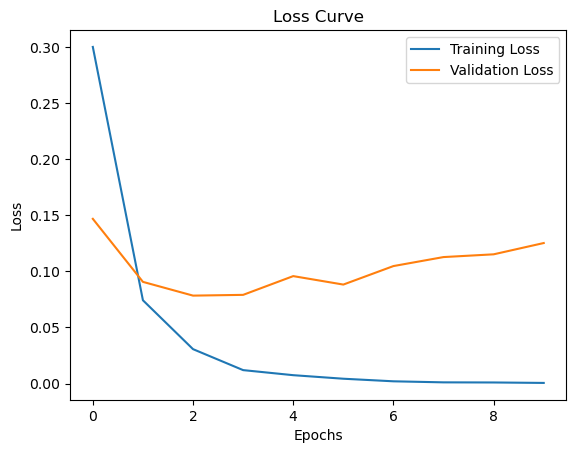

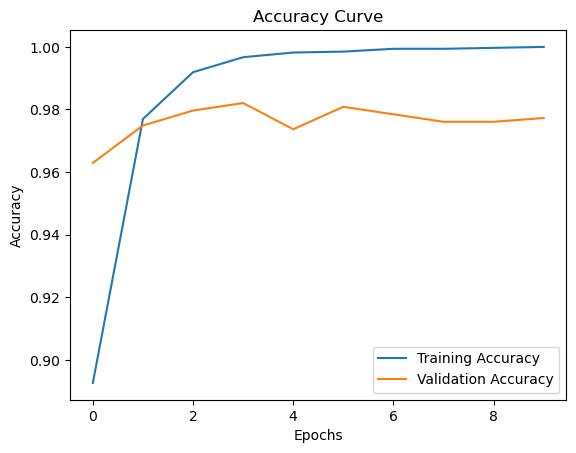

In [78]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


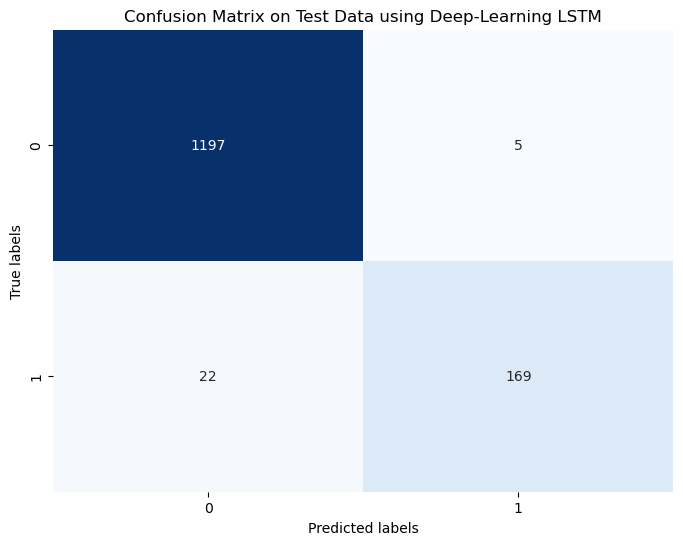

In [79]:
#Confusion Matrix
# Compute confusion matrix
y_pred_val = model.predict(x_test_pad)

    # Convert predicted probabilities to binary predictions
y_pred_val_binary = (y_pred_val > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_val_binary)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Data using Deep-Learning LSTM')
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


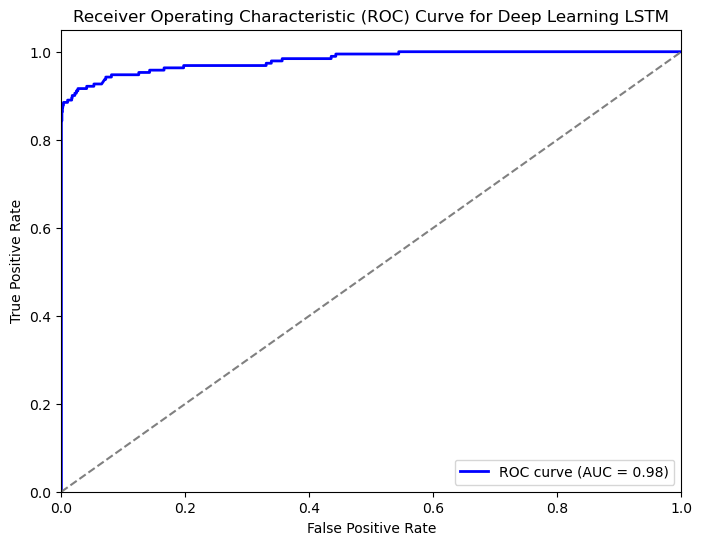

In [80]:
y_score = model.predict(x_test_pad)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Deep Learning LSTM')
plt.legend(loc='lower right')
plt.show()

In [81]:
# Perform cross-validation

# Initialize KFold cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store metrics for each fold
all_metrics = []

for train_index, val_index in kf.split(x_train_pad, y_train):
    x_train_cv, x_val = x_train_pad[train_index], x_train_pad[val_index]
    y_train_cv, y_val = y_train[train_index], y_train[val_index]

    # Train the model
    model.fit(x_train_cv, y_train_cv, epochs=10, batch_size=64, verbose=0)

    # Evaluate the model on validation data
    loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
    y_pred_val = model.predict(x_val)

    # Convert predicted probabilities to binary predictions
    y_pred_val_binary = (y_pred_val > 0.5).astype(int)
    metrics["loss"]=loss
    metrics = calculate_metrics(y_val, y_pred_val_binary)
    all_metrics.append(metrics)

# Calculate average metrics across all folds
df_results_Deep_Learning_LSTM = pd.DataFrame(all_metrics)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [82]:
df_results_Deep_Learning_LSTM.to_csv("df_results_Deep_Learning_LSTM.csv")

In [83]:
df_results_Deep_Learning_LSTM

,TP,TN,FP,FN,TSS,HSS,Accuracy,Precision,Recall,F1-Score,loss
0,45,370,1,2,0.95,0.96,0.99,0.98,0.96,0.97,1.109432e-04
1,54,364,0,0,1.00,1.00,1.00,1.00,1.00,1.00,2.065548e-05
2,53,365,0,0,1.00,1.00,1.00,1.00,1.00,1.00,4.127376e-05
3,60,358,0,0,1.00,1.00,1.00,1.00,1.00,1.00,6.341082e-06
4,65,353,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.256524e-06
5,56,362,0,0,1.00,1.00,1.00,1.00,1.00,1.00,2.381788e-06
6,59,359,0,0,1.00,1.00,1.00,1.00,1.00,1.00,6.845333e-07
7,55,363,0,0,1.00,1.00,1.00,1.00,1.00,1.00,4.097182e-07
8,56,362,0,0,1.00,1.00,1.00,1.00,1.00,1.00,4.996999e-07
9,51,366,0,0,1.00,1.00,1.00,1.00,1.00,1.00,NaN


In [84]:
# Average of 10 Folds execution
dlstm={}
for i in df_results_Deep_Learning_LSTM.columns:
  dlstm[i]=df_results_Deep_Learning_LSTM[i].mean().round(2)
print("Average of 10 Folds")
print(dlstm)

Average of 10 Folds
{'TP': 55.4, 'TN': 362.2, 'FP': 0.1, 'FN': 0.2, 'TSS': 0.99, 'HSS': 1.0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'loss': 0.0}


In [87]:

# Assuming drf, dnb, and dlstm are defined somewhere in your code and hold different results
df_random_forest = pd.DataFrame([drf], index=['Random Forest'])
df_naive_bayes = pd.DataFrame([dnb], index=['Naive Bayes'])
df_lstm = pd.DataFrame([dlstm], index=['Deep Learning LSTM'])

# Concatenate all the dataframes into a single one for comparison
df_comparison = pd.concat([df_random_forest, df_naive_bayes, df_lstm])

# Display the comparison DataFrame
print("Comparison of Average Results Across 10 Folds:")
print(df_comparison)


Comparison of Average Results Across 10 Folds:
                      TP     TN    FP    FN   TSS   HSS  Accuracy  Precision  \
Random Forest       38.2  357.9   4.4  17.4  0.67  0.74      0.95       0.89   
Naive Bayes         43.9  311.0  51.3  11.7  0.64  0.50      0.85       0.46   
Deep Learning LSTM  55.4  362.2   0.1   0.2  0.99  1.00      1.00       1.00   

                    Recall  F1-Score  loss  
Random Forest         0.68      0.77   NaN  
Naive Bayes           0.79      0.58   NaN  
Deep Learning LSTM    1.00      1.00   0.0  
